In [1]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
device = 'cuda'
configs = get_all_experiments_info('outputs/', False)
cfg = [c for c in configs if 'mnist_bernoulli' in c['name'] 
                    and c['config']['experiment']['batch_size'] == 8]

In [3]:
# load + prep dataset
def prepare_dataset(dataset_cfg):
    # probs = np.column_stack((np.linspace(0, 1, num_probs), 1 - np.linspace(0, 1, num_probs)))
    dataset = hydra.utils.instantiate(dataset_cfg)
    # dataset.probs = probs
    # dataset.data, _, _ = dataset.make_sets()
    return dataset

# load encoder and move to device
def load_encoder(cfg, path, device):
    enc = hydra.utils.instantiate(cfg)
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    enc.eval()
    enc.to(device)
    return enc

[1, 10, 0.01, 100, 0.1]

In [49]:
num_samples = 200
dataset = prepare_dataset(cfg[0]['config']['dataset'])

/orcd/data/omarabu/001/gokul/DistributionEmbeddings/datasets/mnist.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(self.mnist.targets)


In [57]:
encoder = load_encoder(cfg[0]['config']['encoder'], 
                       cfg[0]['dir'], 'cuda')

In [58]:
dataset.prob = np.array(dataset.prob)

In [59]:
fr = torch.tensor(dataset.fisher_rao_distance(dataset.prob[:num_samples]))

/orcd/data/omarabu/001/gokul/DistributionEmbeddings/datasets/mnist.py:161: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(np.sqrt(probs[:, None, :] * probs[None, :, :]).sum(axis=2))


In [64]:
d = {}

d['FR'] = fr.cpu().ravel()

with torch.no_grad():
    x = torch.tensor(dataset.data[:num_samples], dtype=torch.float32).to(device)

    for c in cfg:

        encoder = load_encoder(c['config']['encoder'], 
                       c['dir'], 'cuda')
        
        z = encoder(x)
        l2s = torch.cdist(z, z, p=2)

        d[c['config']['dataset']['alpha']] = l2s.cpu().ravel()

/tmp/ipykernel_2260360/2998498900.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(dataset.data[:num_samples], dtype=torch.float32).to(device)


In [65]:
a, b = np.meshgrid(dataset.prob[:num_samples, 0], dataset.prob[:num_samples, 0])
pairs = np.stack([a.ravel(), b.ravel()], axis=1)
d['P1'] = pairs[:, 0]
d['P2'] = pairs[:, 1]

In [94]:
df = pd.DataFrame(d)
cols = df.columns.difference(['P1', 'P2'])
df[cols] = (df[cols] - df[cols].min()) / (df[cols].max() - df[cols].min())
df = df.melt(id_vars =['P1', 'P2', 'FR'], 
        value_vars=[cfg[i]['config']['dataset']['alpha'] for i in range(len(cfg))],
        var_name='alpha', value_name='Latent L2')
df.head()

,P1,P2,FR,alpha,Latent L2
0,0.134871,0.134871,0.000000,1,0.000914
1,0.843312,0.134871,0.558301,1,0.541151
2,0.028893,0.134871,0.145456,1,0.181974
3,0.983388,0.134871,0.755133,1,0.635672
4,0.882136,0.134871,0.598370,1,0.583021


In [97]:
from scipy.stats import pearsonr
from matplotlib import rcParams
rcParams['figure.dpi'] = 300

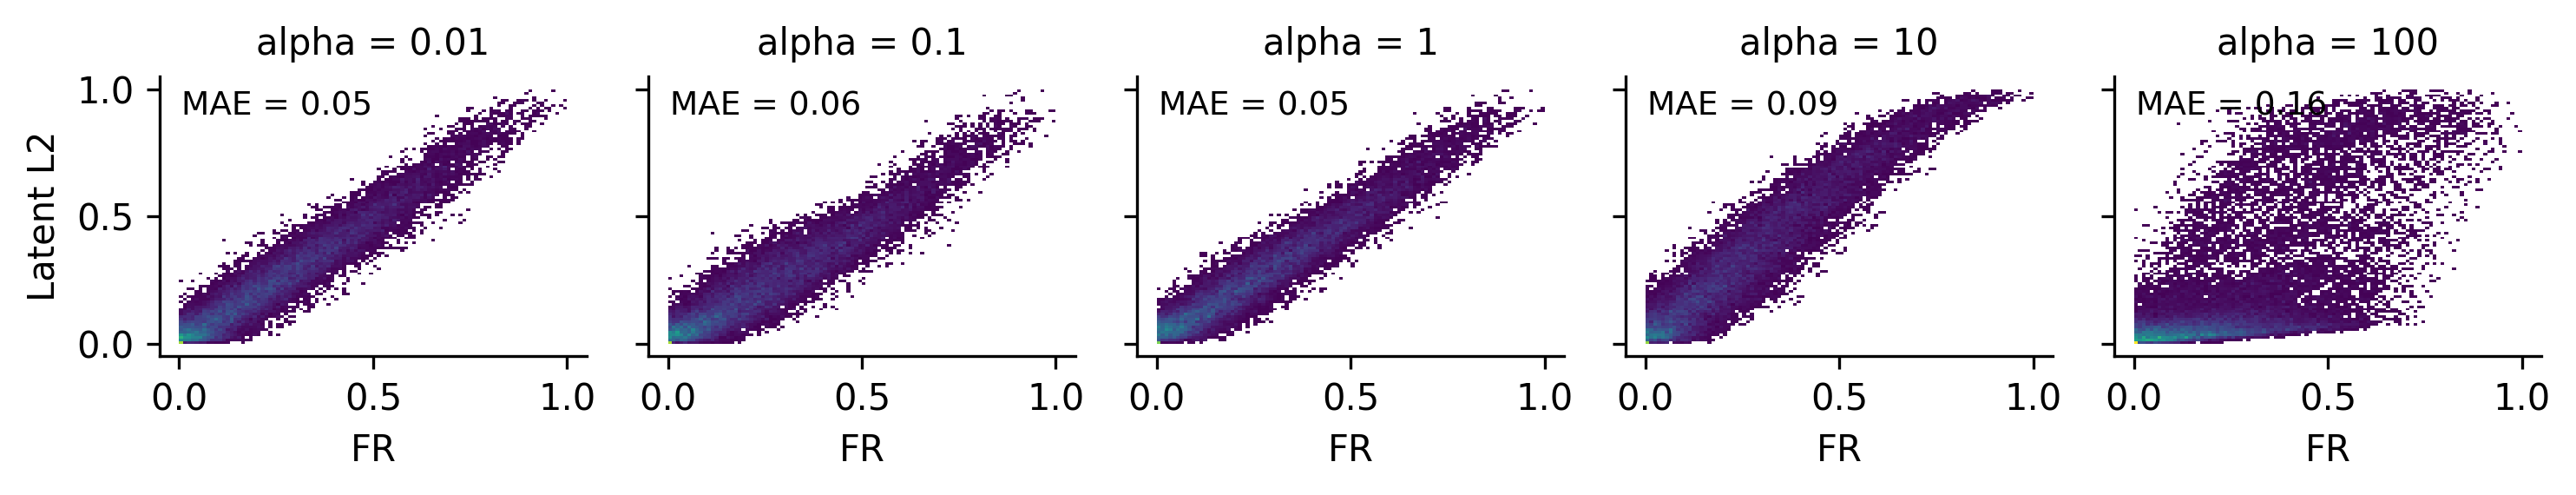

In [109]:
g = sns.displot(
    df, x='FR', y='Latent L2',
    col='alpha', kind='hist',
    cmap='viridis', bins=100,
    facet_kws=dict(margin_titles=True),
    height=2, aspect=1,
)

# annotate each subplot with Pearson r :)
for val, ax in zip(g.col_names, g.axes.flat):
    sub = df[df['alpha'] == val]
    mae = np.mean(np.abs(np.nan_to_num(sub['FR'].values) - 
                    np.nan_to_num(sub['Latent L2'].values)))
    ax.text(0.05, 0.95, f"MAE = {mae:.2f}", transform=ax.transAxes,
            ha='left', va='top', fontsize=9, color='black')